# Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
pd.set_option("mode.chained_assignment",None)
import numpy as np
import os
import sys

from plotnine import *
import scipy

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

# Load data

In [2]:
data_filepath = r"/Users/gardy/Documents/GardyL/Statistiques/Stats Marie B/2022/EPICEA-database-article_V4_ranking only.xlsx"
patients_df = pd.read_excel(data_filepath)
print(patients_df)

    Nom  Num  Age  sexe  PharmacoRes  PMAs  EME_DE_NOVO  Duree_EME_min  STESS  \
0    SA    1   79     1            1     1            1           7000      6   
1    QD    2   80     1            1     0            1           7200      4   
2    VA    3   59     0            1     0            1             20      3   
3    AC    4   69     0            0     0            1            100      4   
4    PA    5   75     1            0     1            1             40      3   
..   ..  ...  ...   ...          ...   ...          ...            ...    ...   
427  RO  105   33     0            1     0            0             45      2   
428  MR  106   73     0            0     0            0            720      2   
429  AD  107   36     1            0     0            0             40      1   
430  AA  108   17     1            1     0            0           2800      3   
431  TG  109   57     0            1     0            0            300      1   

     EMSE  Ranking_score Ra

# Reorder data

In [3]:
patients_df['EME_DE_NOVO'][patients_df['EME_DE_NOVO'] == 0] = "NISE"
patients_df['EME_DE_NOVO'][patients_df['EME_DE_NOVO'] == 1] = "NOSE"

patients_df['PMAs'][patients_df['PMAs'] == 0] = "noPMA"
patients_df['PMAs'][patients_df['PMAs'] == 1] = "PMA"

patients_df['PharmacoRes'][patients_df['PharmacoRes'] == 0] = "noPR"
patients_df['PharmacoRes'][patients_df['PharmacoRes'] == 1] = "PR"

patients_df['Ranking_time'][patients_df['Ranking_time'] == "pre-EME"] = np.int64(0)#"1. pre-EME"
patients_df['Ranking_time'][patients_df['Ranking_time'] == "M1"] = np.int64(1)#"2. M1"
patients_df['Ranking_time'][patients_df['Ranking_time'] == "M3"] = np.int64(2)#"3. M3"
patients_df['Ranking_time'][patients_df['Ranking_time'] == "M12"] = np.int64(3) #"4. M12"

# 1. NISE vs NOSE
## 1.1. Boxplots

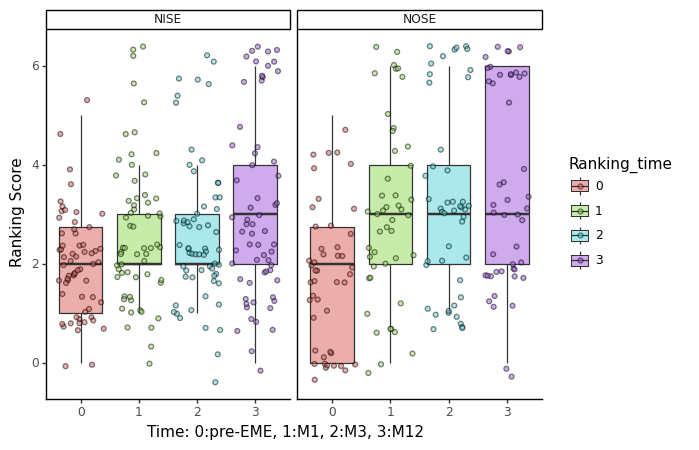

<ggplot: (699109241)>

In [4]:
boxplot_1 = (ggplot(patients_df)
    + aes(x='Ranking_time', y = 'Ranking_score', fill = 'Ranking_time')
    + geom_boxplot(outlier_alpha = 0, alpha = 0.5)
    + geom_jitter(alpha = 0.5)
    + labs(x='Time: 0:pre-EME, 1:M1, 2:M3, 3:M12', y='Ranking Score')             
    + theme_classic()          
    + facet_wrap('EME_DE_NOVO', ncol = 2)
    )

boxplot_1

## 1.2. Linear regressions

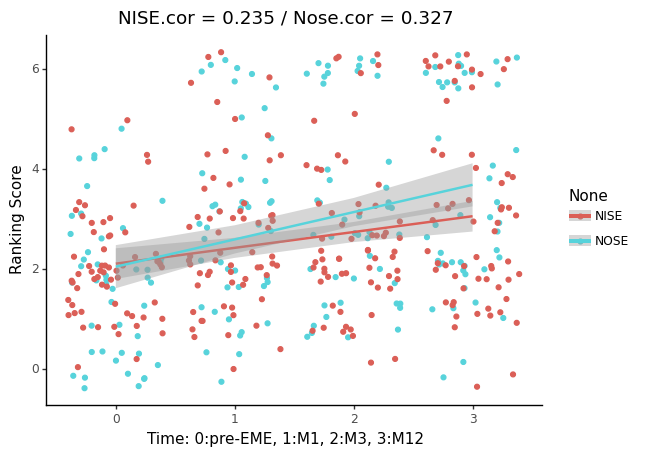

<ggplot: (699277602)>

In [5]:
### Manually set x,y,z types or linear regression does not work
x = np.array(patients_df['Ranking_time']).astype(np.int64)
y = np.array(patients_df['Ranking_score'])
z = np.array(patients_df['EME_DE_NOVO'])

### Calculate Pearson correlations
r_NISE = np.round(np.corrcoef(x[z=="NISE"], y[z=="NISE"])[0,1],3)
r_NOSE = np.round(np.corrcoef(x[z=="NOSE"], y[z=="NOSE"])[0,1],3)

### Plot linear regression
lreg_1 = (ggplot()
    + aes(x=x, y = y, color = z)
    + geom_jitter()
    + geom_smooth(method='lm')
    #+ geom_line(aes(x='Raking_moment', y = 'Ranking_score', color = 'EME DE NOVO'))
    + labs(x='Time: 0:pre-EME, 1:M1, 2:M3, 3:M12', y='Ranking Score', title=f'NISE.cor = {r_NISE} / Nose.cor = {r_NOSE}')             
    + theme_classic()          
    )

lreg_1

## 1.3. Mixed effects model

In [6]:
md = smf.mixedlm("Ranking_score ~ EME_DE_NOVO + Ranking_time + EME_DE_NOVO:Ranking_time", patients_df, groups=patients_df["Num"])
mdf = md.fit()
summary = mdf.summary()
print(summary)
#summary.tables[1]['Coef.']

                     Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        Ranking_score
No. Observations:        432            Method:                    REML         
No. Groups:              108            Scale:                     0.6706       
Min. group size:         4              Log-Likelihood:            -665.5287    
Max. group size:         4              Converged:                 Yes          
Mean group size:         4.0                                                    
--------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                              2.016    0.203  9.936 0.000  1.618  2.414
EME_DE_NOVO[T.NOSE]                   -0.277    0.311 -0.891 0.373 -0.886  0.332
Ranking_time[T.1]                      0.597    0.

<span style="color:red;font-weight:400;font-size:14px">
There is no global effect of being NOSE vs being NISE. Nevertheless, there is an interaction between EME_DE_NOVO (NOSE/NISE) and Raking_time (pre-EME, M1, M3, M12). This means that the ranking_score between "pre-EME" and "M12", evolves in different proportions (at different a "speed") in the two groups of patients.
<span>

### Patients NISE
- Patients NISE have an average ranking of 2.016 at time "pre-EME". _**`Total: 2.016`**_
- Patients NISE have an average ranking of 2.016 + 0.597 at time "M1". _**`Total: 2.613`**_ 
- Patients NISE have an average ranking of 2.016 + 0.613 at time "M3". _**`Total: 2.629`**_
- Patients NISE have an average ranking of 2.016 + 1.048 at time "M12". _**`Total: 3.064`**_ 

### Patients NOSE
- Patients NOSE have an average ranking of 2.016 + (0.283-0.283) at time "pre-EME". _**`Total: 2.016`**_
- Patients NOSE have an average ranking of 2.016 + (0.283-0.283) + 0.597  + 0.686 at time "M1". _**`Total: 3.299`**_
- Patients NOSE have an average ranking of 2.016 + (0.283-0.283) + 0.613  + 0.844 at time "M3".  _**`Total: 3.473`**_
- Patients NOSE have an average ranking of 2.016 + (0.283-0.283) + 1.048  + 0.712 at time "M12". _**`Total: 3.776`**_

As the intercept is not different between NISE and NOSE patients (p=0.373), its effect was removed from calculations (EME effect = 0.283-0.283 = 0).

### Let us plot the ranking slope over time for NISE and NOSE patients

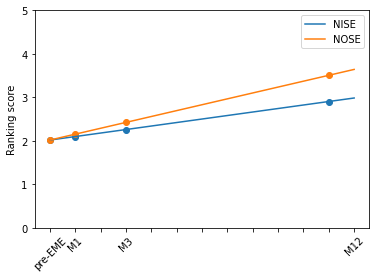

In [7]:
x_vals = np.arange(0,13)

intercept_NISE = 2.016
slope_NISE = (3.064-intercept_NISE) / 13 # 13 month between pre-EME and M12
#NISE_line = intercept_NISE + slope_NISE * x_vals
NISE_line = np.arange(intercept_NISE, intercept_NISE+slope_NISE*13, slope_NISE)

intercept_NOSE = 2.016 + (0.283-0.283)
slope_NOSE = (3.776-intercept_NOSE) / 13 # 13 month between pre-EME and M12
#NOSE_line  = intercept_NOSE + slope_NOSE * x_vals
NOSE_line = np.arange(intercept_NOSE, intercept_NOSE+slope_NOSE*13, slope_NOSE)

f, ax = plt.subplots()

ax.set_ylabel("Ranking score")
ax.plot(x_vals, NISE_line)
ax.plot(x_vals, NOSE_line)
ax.set_ylim(0,5)
ax.scatter([0,1,3,11], [NISE_line[0], NISE_line[1], NISE_line[3], NISE_line[11]])
ax.scatter([0,1,3,11], [NOSE_line[0], NOSE_line[1], NOSE_line[3], NOSE_line[11]])
ax.set_xticks(np.arange(0,13),rotation=90)
ax.set_xticklabels(["pre-EME", "M1", "", "M3", "", "", "", "", "", "", "", "", "M12"],  rotation = 45);
ax.legend(["NISE","NOSE"])

## 1.4. Post-hoc
### Patients NISE

In [8]:
tukeyHSD = statsmodels.stats.multicomp.pairwise_tukeyhsd(patients_df["Ranking_score"][patients_df["EME_DE_NOVO"]=="NISE"], patients_df["Ranking_time"][patients_df["EME_DE_NOVO"]=="NISE"], alpha=0.05)
tukeyHSD.summary()


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,0.5968,0.1096,-0.0853,1.2789,False
0,2,0.6129,0.0953,-0.0692,1.295,False
0,3,1.0484,0.0005,0.3663,1.7305,True
1,2,0.0161,0.9999,-0.666,0.6982,False
1,3,0.4516,0.3193,-0.2305,1.1337,False
2,3,0.4355,0.3518,-0.2466,1.1176,False


### Patients NOSE

In [9]:
tukeyHSD = statsmodels.stats.multicomp.pairwise_tukeyhsd(patients_df["Ranking_score"][patients_df["EME_DE_NOVO"]=="NOSE"], patients_df["Ranking_time"][patients_df["EME_DE_NOVO"]=="NOSE"], alpha=0.05)
tukeyHSD.summary()


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,1.2826,0.0033,0.3318,2.2334,True
0,2,1.4565,0.0006,0.5057,2.4073,True
0,3,1.7609,0.0,0.81,2.7117,True
1,2,0.1739,0.9646,-0.7769,1.1247,False
1,3,0.4783,0.5614,-0.4726,1.4291,False
2,3,0.3043,0.8401,-0.6465,1.2552,False


### 1.4.1. Post-hoc results
<span style="color:red;font-weight:400;font-size:14px">
As the ranking_time has a different effect on NOSE and NISE patients, we analysed these two groups independantly.

- For NISE patients, ranking at pre-EME is different from ranking at M12 only (diff = 1.05; p adj. = 0.0005).
- For NOSE patients, ranking at pre-EME is different from ranking at M1 (diff = 1.28; p adj. = 0.0033), M3 (diff = 1.46; p adj. = 0.0006) and M12 (diff = 1.76; p adj. = 0).
<span>


# 2. With MRI anomaly (PMA) vs without MRI anomaly (noPMA)
## 2.1. Boxplots

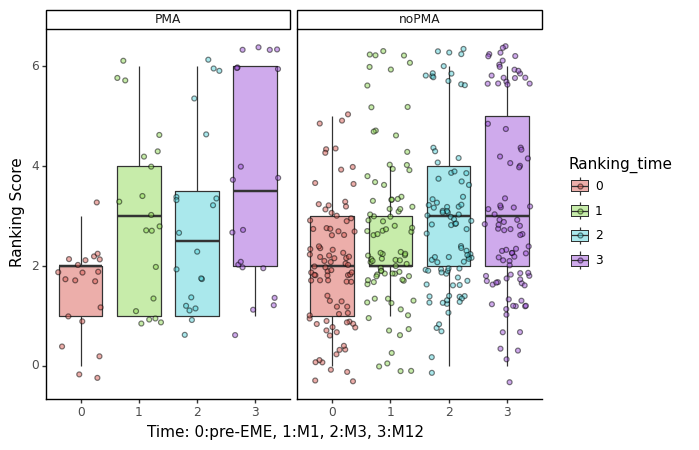

<ggplot: (700587671)>

In [10]:
boxplot_2 = (ggplot(patients_df)
    + aes(x='Ranking_time', y = 'Ranking_score', fill = 'Ranking_time')
    + geom_boxplot(outlier_alpha = 0, alpha = 0.5)
    + geom_jitter(alpha = 0.5)
    + labs(x='Time: 0:pre-EME, 1:M1, 2:M3, 3:M12', y='Ranking Score')             
    + theme_classic()          
    + facet_wrap('PMAs', ncol = 2)
    )

boxplot_2

## 2.2. Linear regressions

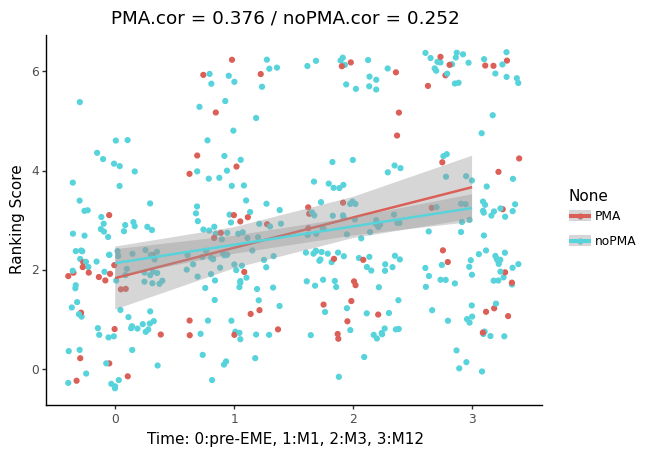

<ggplot: (700579322)>

In [11]:
### Manually set x,y,z types or linear regression does not work
x = np.array(patients_df['Ranking_time']).astype(np.int64)
y = np.array(patients_df['Ranking_score'])
z = np.array(patients_df['PMAs'])

### Calculate Pearson correlations
r_PMA = np.round(np.corrcoef(x[z=="PMA"], y[z=="PMA"])[0,1],3)
r_noPMA = np.round(np.corrcoef(x[z=="noPMA"], y[z=="noPMA"])[0,1],3)

### Plot linear regression
lreg_1 = (ggplot()
    + aes(x=x, y = y, color = z)
    + geom_jitter()
    + geom_smooth(method='lm')
    + labs(x='Time: 0:pre-EME, 1:M1, 2:M3, 3:M12', y='Ranking Score', title=f'PMA.cor = {r_PMA} / noPMA.cor = {r_noPMA}')             
    + theme_classic()          
    )

lreg_1

## 2.3. Mixed effects model

In [12]:
md = smf.mixedlm("Ranking_score ~ PMAs + Ranking_time + PMAs:Ranking_time", patients_df, groups=patients_df["Num"])
mdf = md.fit()
summary = mdf.summary()
print(summary)
#summary.tables[1]['Coef.']

                  Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Ranking_score
No. Observations:      432          Method:                  REML         
No. Groups:            108          Scale:                   0.6802       
Min. group size:       4            Log-Likelihood:          -667.3329    
Max. group size:       4            Converged:               Yes          
Mean group size:       4.0                                                
--------------------------------------------------------------------------
                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                        1.500    0.359  4.177 0.000  0.796  2.204
PMAs[T.noPMA]                    0.489    0.398  1.228 0.219 -0.291  1.268
Ranking_time[T.1]                1.550    0.261  5.943 0.000  1.039  2.061
Ranking_time[T.2]                1.350    0.

<span style="color:green;font-weight:400;font-size:14px">
There is no global effect of being PMA vs being noPMA. Nevertheless, there is an interaction between PMAs (PMA/noPMA) and Raking_time (pre-EME, M1, M3, M12). This means that the ranking_score between "pre-EME" and "M12", evolves in different proportions (at different a "speed") in the two groups of patients.
</span>

### Patients PMA
- Patients PMA have an average ranking of 1.500 at time "pre-EME". _**`Total: 1.5`**_
- Patients PMA have an average ranking of 1.500 + 1.550 at time "M1". _**`Total: 3.1`**_ 
- Patients PMA have an average ranking of 1.500 + 1.350 at time "M3". _**`Total: 2.85`**_
- Patients PMA have an average ranking of 1.500 + 2.100 at time "M12". _**`Total: 3.6`**_ 

### Patients noPMA
- Patients noPMA have an average ranking of 1.500 + (-0.489+0.489) at time "pre-EME". _**`Total: 1.5`**_
- Patients noPMA have an average ranking of 1.500 + (-0.489+0.489) + 1.550 - 0.811  at time "M1". _**`Total: 2.24`**_
- Patients noPMA have an average ranking of 1.500 + (-0.489+0.489) + 1.350 - (0.464+0.464)  at time "M3".  _**`Total: 2.85`**_
- Patients noPMA have an average ranking of 1.500 + (-0.489+0.489) + 2.100  - 0.918 at time "M12". _**`Total: 2.68`**_

As the intercept is not different between PMA and noPMA patients (p=0.219), its effect was removed from calculations (EME effect = 0.489-0.489 = 0).

### Let us plot the ranking slope over time for PMA and noPMA patients

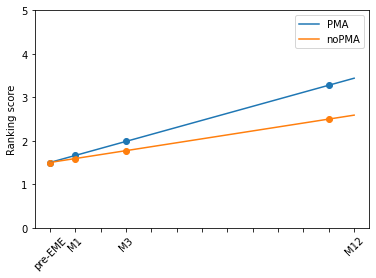

In [13]:
x_vals = np.arange(0,13)

intercept_PMA = 1.5
slope_PMA = (3.6-intercept_PMA) / 13 # 13 month between pre-EME and M12
PMA_line = np.arange(intercept_PMA, intercept_PMA+slope_PMA*13, slope_PMA)

intercept_noPMA = 1.5 + (-0.489+0.489)
slope_noPMA = (2.68-intercept_noPMA) / 13 # 13 month between pre-EME and M12
noPMA_line = np.arange(intercept_noPMA, intercept_noPMA+slope_noPMA*13, slope_noPMA)

f, ax = plt.subplots()

ax.set_ylabel("Ranking score")
ax.plot(x_vals, PMA_line)
ax.plot(x_vals, noPMA_line)
ax.set_ylim(0,5)
ax.scatter([0,1,3,11], [PMA_line[0], PMA_line[1], PMA_line[3], PMA_line[11]])
ax.scatter([0,1,3,11], [noPMA_line[0], noPMA_line[1], noPMA_line[3], noPMA_line[11]])
ax.set_xticks(np.arange(0,13),rotation=90)
ax.set_xticklabels(["pre-EME", "M1", "", "M3", "", "", "", "", "", "", "", "", "M12"],  rotation = 45);
ax.legend(["PMA","noPMA"])

## 2.4. Post-hoc
### Patients PMA

In [14]:
tukeyHSD = statsmodels.stats.multicomp.pairwise_tukeyhsd(patients_df["Ranking_score"][patients_df["PMAs"]=="PMA"], patients_df["Ranking_time"][patients_df["PMAs"]=="PMA"], alpha=0.05)
tukeyHSD.summary()


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,1.55,0.0238,0.1519,2.9481,True
0,2,1.35,0.0623,-0.0481,2.7481,False
0,3,2.1,0.001,0.7019,3.4981,True
1,2,-0.2,0.9818,-1.5981,1.1981,False
1,3,0.55,0.7305,-0.8481,1.9481,False
2,3,0.75,0.4976,-0.6481,2.1481,False


### Patients noPMA

In [15]:
tukeyHSD = statsmodels.stats.multicomp.pairwise_tukeyhsd(patients_df["Ranking_score"][patients_df["PMAs"]=="noPMA"], patients_df["Ranking_time"][patients_df["PMAs"]=="noPMA"], alpha=0.05)
tukeyHSD.summary()


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,0.7386,0.0118,0.1203,1.357,True
0,2,0.8864,0.0014,0.268,1.5047,True
0,3,1.1818,0.0,0.5635,1.8002,True
1,2,0.1477,0.9267,-0.4706,0.7661,False
1,3,0.4432,0.2517,-0.1752,1.0615,False
2,3,0.2955,0.606,-0.3229,0.9138,False


### 2.4.1. Post-hoc results
<span style="color:green;font-weight:400;font-size:14px">
As the ranking_time has a different effect on PMA and noPMA patients, we analysed these two groups independantly.

- For PMA patients, ranking at pre-EME is different from ranking at M1 (diff = 1.55; p adj. = 0.024) and at M12 (diff = 2.1; p adj. = 0.001).
- For noPMA patients, ranking at pre-EME is different from ranking at M1 (diff = 0.73; p adj. = 0.01), M3 (diff = 0.89; p adj. = 0.001) and M12 (diff = 1.18; p adj. = 0).
<span>


# 3. Pharmacoresistant (PR) vs not pharmacoresistant (noPR)
## 3.1. Boxplots

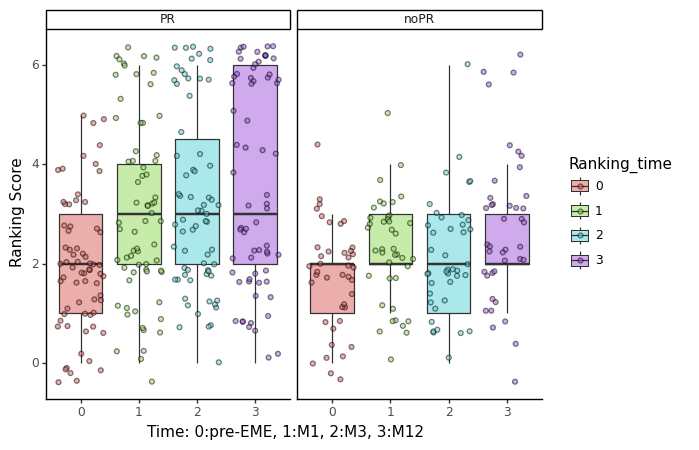

<ggplot: (700741500)>

In [16]:
boxplot_3 = (ggplot(patients_df)
    + aes(x='Ranking_time', y = 'Ranking_score', fill = 'Ranking_time')
    + geom_boxplot(outlier_alpha = 0, alpha = 0.5)
    + geom_jitter(alpha = 0.5)
    + labs(x='Time: 0:pre-EME, 1:M1, 2:M3, 3:M12', y='Ranking Score')             
    + theme_classic()          
    + facet_wrap('PharmacoRes', ncol = 2)
    )

boxplot_3

## 3.2. Linear regressions

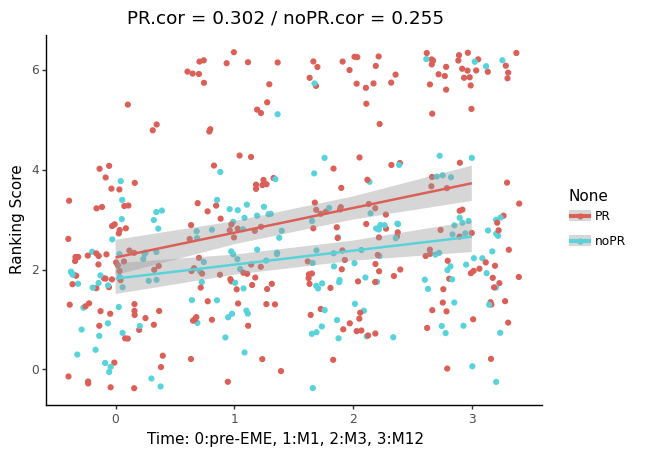

<ggplot: (700838852)>

In [17]:
### Manually set x,y,z types or linear regression does not work
x = np.array(patients_df['Ranking_time']).astype(np.int64)
y = np.array(patients_df['Ranking_score'])
z = np.array(patients_df['PharmacoRes'])

### Calculate Pearson correlations
r_PR = np.round(np.corrcoef(x[z=="PR"], y[z=="PR"])[0,1],3)
r_noPR = np.round(np.corrcoef(x[z=="noPR"], y[z=="noPR"])[0,1],3)

### Plot linear regression
lreg_1 = (ggplot()
    + aes(x=x, y = y, color = z)
    + geom_jitter()
    + geom_smooth(method='lm')
    + labs(x='Time: 0:pre-EME, 1:M1, 2:M3, 3:M12', y='Ranking Score', title=f'PR.cor = {r_PR} / noPR.cor = {r_noPR}')             
    + theme_classic()          
    )

lreg_1

## 3.3. Mixed effect model

In [18]:
md = smf.mixedlm("Ranking_score ~ PharmacoRes + Ranking_time + PharmacoRes:Ranking_time", patients_df, groups=patients_df["Num"])
mdf = md.fit()
summary = mdf.summary()
print(summary)
#summary.tables[1]['Coef.']

                     Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        Ranking_score
No. Observations:        432            Method:                    REML         
No. Groups:              108            Scale:                     0.6837       
Min. group size:         4              Log-Likelihood:            -665.5012    
Max. group size:         4              Converged:                 Yes          
Mean group size:         4.0                                                    
--------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                              2.015    0.191 10.539 0.000  1.640  2.390
PharmacoRes[T.noPR]                   -0.308    0.310 -0.991 0.322 -0.916  0.301
Ranking_time[T.1]                      1.060    0.

<span style="color:blue;font-weight:400;font-size:14px">
There is no global effect of being PR vs being noPR. Nevertheless, there is an interaction between PRs (PR/noPR) and Raking_time (pre-EME, M1, M3, M12). This means that the ranking_score between "pre-EME" and "M12", evolves in different proportions (at different a "speed") in the two groups of patients.
</span>

### Patients PR
- Patients PMA have an average ranking of 2.015 at time "pre-EME". _**`Total: 2.015`**_
- Patients PMA have an average ranking of 2.015 + 1.060 at time "M1". _**`Total: 3.08`**_ 
- Patients PMA have an average ranking of 2.015 + 1.224 at time "M3". _**`Total: 3.24`**_
- Patients PMA have an average ranking of 2.015 + 1.597 at time "M12". _**`Total: 3.6`**_ 

### Patients noPR
- Patients noPMA have an average ranking of 2.015 + (-0.308+0.308) at time "pre-EME". _**`Total: 2.015`**_
- Patients noPMA have an average ranking of 2.015 + (-0.308+0.308) + 1.060 - (0.450+0.450)  at time "M1". _**`Total: 3.08`**_
- Patients noPMA have an average ranking of 2.015 + (-0.308+0.308) + 1.224 - 0.663  at time "M3".  _**`Total: 2.58`**_
- Patients noPMA have an average ranking of 2.015 + (-0.308+0.308) + 1.597  - 0.646 at time "M12". _**`Total: 2.97`**_

As the intercept is not different between PMA and noPMA patients (p=0.322), its effect was removed from calculations (EME effect = 0.308-0.308 = 0).

### Let us plot the ranking slope over time for PMA and noPMA patients

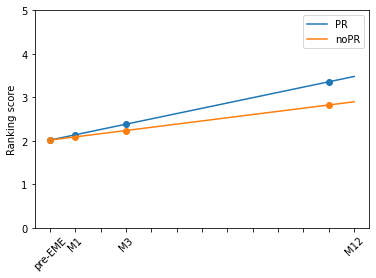

In [19]:
x_vals = np.arange(0,13)

intercept_PR = 2.015
slope_PR = (3.6-intercept_PR) / 13 # 13 month between pre-EME and M12
PR_line = np.arange(intercept_PR, intercept_PR+slope_PR*13, slope_PR)

intercept_noPR = 2.015 + (-0.450+0.450)
slope_noPR = (2.97-intercept_noPR) / 13 # 13 month between pre-EME and M12
noPR_line = np.arange(intercept_noPR, intercept_noPR+slope_noPR*13, slope_noPR)

f, ax = plt.subplots()

ax.set_ylabel("Ranking score")
ax.plot(x_vals, PR_line)
ax.plot(x_vals, noPR_line)
ax.set_ylim(0,5)
ax.scatter([0,1,3,11], [PR_line[0], PR_line[1], PR_line[3], PR_line[11]])
ax.scatter([0,1,3,11], [noPR_line[0], noPR_line[1], noPR_line[3], noPR_line[11]])
ax.set_xticks(np.arange(0,13),rotation=90)
ax.set_xticklabels(["pre-EME", "M1", "", "M3", "", "", "", "", "", "", "", "", "M12"],  rotation = 45);
ax.legend(["PR","noPR"])

## 3.4. Post-hoc
### Patients PR

In [20]:
tukeyHSD = statsmodels.stats.multicomp.pairwise_tukeyhsd(patients_df["Ranking_score"][patients_df["PharmacoRes"]=="PR"], patients_df["Ranking_time"][patients_df["PharmacoRes"]=="PR"], alpha=0.05)
tukeyHSD.summary()


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,1.0597,0.003,0.2774,1.842,True
0,2,1.2239,0.0004,0.4416,2.0062,True
0,3,1.597,0.0,0.8147,2.3793,True
1,2,0.1642,0.9485,-0.6181,0.9465,False
1,3,0.5373,0.2873,-0.245,1.3196,False
2,3,0.3731,0.6063,-0.4092,1.1554,False


### Patients noPR

In [21]:
tukeyHSD = statsmodels.stats.multicomp.pairwise_tukeyhsd(patients_df["Ranking_score"][patients_df["PharmacoRes"]=="noPR"], patients_df["Ranking_time"][patients_df["PharmacoRes"]=="noPR"], alpha=0.05)
tukeyHSD.summary()


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,0.6098,0.1001,-0.0757,1.2952,False
0,2,0.561,0.1497,-0.1245,1.2464,False
0,3,0.9512,0.0024,0.2658,1.6367,True
1,2,-0.0488,0.9978,-0.7342,0.6367,False
1,3,0.3415,0.5685,-0.344,1.0269,False
2,3,0.3902,0.4531,-0.2952,1.0757,False


### 3.4.1. Post-hoc results
<span style="color:blue;font-weight:400;font-size:14px">
As the ranking_time has a different effect on PR and noPR patients, we analysed these two groups independantly.

- For PR patients, ranking at pre-EME is different from ranking at M1 (diff = 1.06; p adj. = 0.003), M3 (diff = 1.24; p adj. = 0.0004) and M12 (diff = 1.6; p adj. = 0).
- For noPR patients, ranking at pre-EME is different from ranking at M12 only (diff = 0.95; p adj. = 0.002).
<span>


# 4. Correlations

## 4.1. Ranking_score vs EME_duration_min
Patients with a score above 50000 min were removed from dataset.

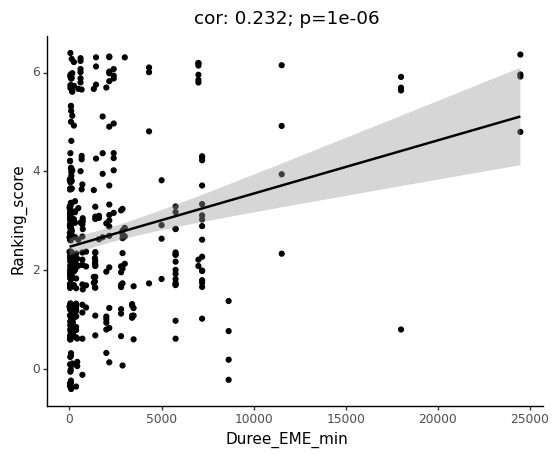

<ggplot: (700840180)>

In [35]:
### Calculate Pearson correlations
x = patients_df['Duree_EME_min'][patients_df['Duree_EME_min'] < 50000]
y = patients_df['Ranking_score'][patients_df['Duree_EME_min'] < 50000]
pearson_res = scipy.stats.pearsonr(x, y, alternative='two-sided')
stat, pval = (np.round(pearson_res[0],3),np.round(pearson_res[1],6))

### Plot linear regression
lreg_1 = (ggplot()
    + aes(x=x, y = y)
    + geom_jitter()
    + geom_smooth(method='lm')
    #+ geom_line(aes(x='Raking_moment', y = 'Ranking_score', color = 'EME DE NOVO'))
    + labs(title=f'cor: {stat}; p={pval}')             
    + theme_classic()          
    )

lreg_1

## 4.2. Ranking_score vs EMSE

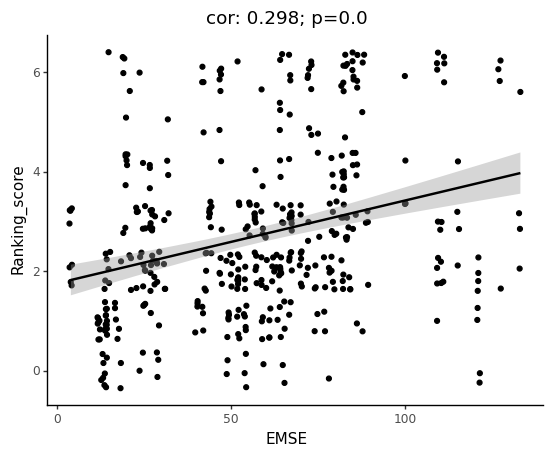

<ggplot: (701072113)>

In [28]:
### Calculate Pearson correlations
x = patients_df['EMSE']
y = patients_df['Ranking_score']
pearson_res = scipy.stats.pearsonr(x, y, alternative='two-sided')
stat, pval = (np.round(pearson_res[0],3),np.round(pearson_res[1],6))

### Plot linear regression
lreg_1 = (ggplot()
    + aes(x=x, y = y)
    + geom_jitter()
    + geom_smooth(method='lm')
    #+ geom_line(aes(x='Raking_moment', y = 'Ranking_score', color = 'EME DE NOVO'))
    + labs(title=f'cor: {stat}; p={pval}')             
    + theme_classic()          
    )

lreg_1

## 4.3. Ranking_score vs STESS

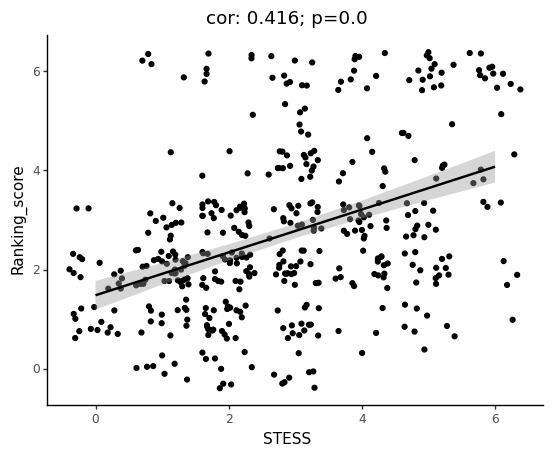

<ggplot: (701107399)>

In [30]:
### Calculate Pearson correlations
x = patients_df['STESS']
y = patients_df['Ranking_score']
pearson_res = scipy.stats.pearsonr(x, y, alternative='two-sided')
stat, pval = (np.round(pearson_res[0],3),np.round(pearson_res[1],6))

### Plot linear regression
lreg_1 = (ggplot()
    + aes(x=x, y = y)
    + geom_jitter()
    + geom_smooth(method='lm')
    #+ geom_line(aes(x='Raking_moment', y = 'Ranking_score', color = 'EME DE NOVO'))
    + labs(title=f'cor: {stat}; p={pval}')             
    + theme_classic()          
    )

lreg_1